# Diagnostic_Crime

In [1]:
import requests
import pandas as pd
import calendar
import json
import folium
import seaborn as sns
import mapclassify
import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import seaborn as sns
from shapely.geometry import Point
import censusgeocode as cg
import warnings
warnings.filterwarnings('ignore')

sns.set(style="ticks", color_codes=True)
%matplotlib inline

### Helper Functions

In [2]:
def get_data(query_json):
    '''
    Generates a DataFrame of crime data using API

    Input: (Request Object) Request made to fetch data using API

    Output: (DataFrame) required Chicago crime data
    '''

    dicto = {}
    count = 0
    for val in query_json.json():
        dicto[count] = val
        count += 1
    df = pd.DataFrame.from_dict(dicto, orient='index')

    return df

def get_request(url_crime):
    '''
    Open a connection to the specified URL and if successful
    read the data.

    Inputs:
        url: must be an absolute URL

    Outputs:
        request object or None

    Examples:
        get_request("http://www.cs.uchicago.edu")
    '''

    try:
        req = requests.get(url_crime)
        if req.status_code == 404 or req.status_code == 403:
            req = None
    except Exception:
        # fail on any kind of error
        req = None

    return req

# Question 1

In [3]:
# Get Crime Data from API for 2017 and 2018
url_crime = "https://data.cityofchicago.org/resource/6zsd-86xi.json?$limit=550000&$where\
=date between '2017-01-01T00:00:00' and '2018-12-31T00:00:00'"
# Customised Functions for extraction 
crime_json = get_request(url_crime)
df = get_data(crime_json)
# Drop rows with missing values
df.dropna(inplace=True) # 1% records without location removed

### Add Neighbourhood to Crime Data using Spatial Join

In [4]:
# Import Neighbourhood Shapefile
nbh_shapefile_path = "/Users/parthkhare/Parth_Repos/Machine-Learning-for-Public-Polcy/Crime_Analysis/Shape/Neighborhoods_98/Neighborhoods_98.shp"
nbh = gpd.read_file(nbh_shapefile_path)
nbh = nbh.to_crs({'init': 'epsg:4326'}) # Set projection

# combine lat and lon column to a shapely Point() object
df['geometry'] = df.apply(lambda x: Point((float(x.longitude), float(x.latitude))), axis=1)
df_point = gpd.GeoDataFrame(df, geometry='geometry')
df_point.crs= "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

# Crime Data for 2017 and 2018 with NBH
crime = gpd.sjoin(df_point, nbh, how="left", op = 'intersects')

### Descriptive Statistics

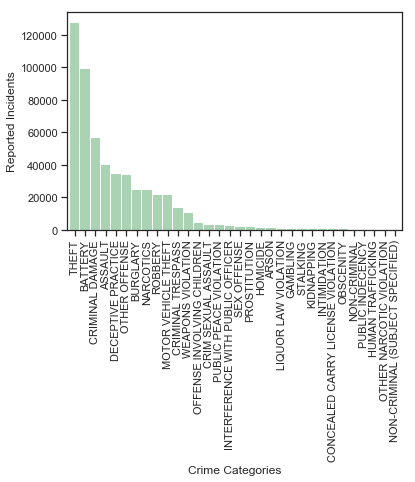

In [5]:
# Descriptive Statistics: Crime Type
ax = crime['primary_type'].value_counts().sort_values(ascending =  False).plot(kind='bar',
                                                            width=0.9,
                                                            color='g',
                                                            alpha=0.5,
                                                            linewidth=0)
ax.set_xlabel('Crime Categories')
ax.set_ylabel('Reported Incidents')
plt.show()

False    0.801828
True     0.198172
Name: arrest, dtype: float64


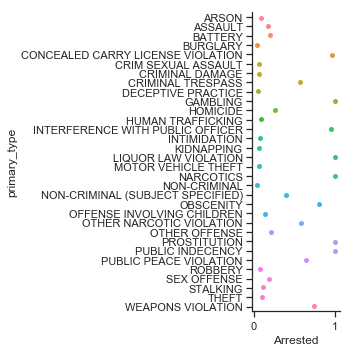

In [6]:
# 20% Arrest made
print(crime.arrest.value_counts(normalize=True))
arst = pd.DataFrame(crime.groupby('primary_type').arrest.value_counts(normalize=True).unstack())
arst = arst.reset_index()
arst.columns.values[[1, 2]] = ['Not Arrested', 'Arrested']
sns.catplot(x='Arrested',y='primary_type',data=arst)

In [7]:
# arst = crime.groupby(['primary_type'])['case_number'].agg('count').reset_index()


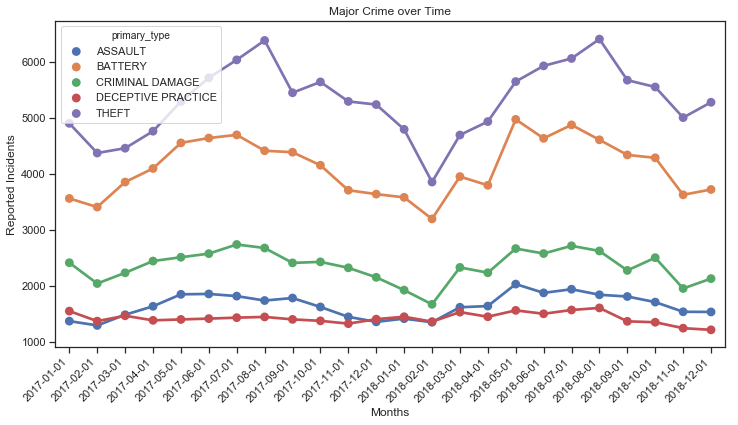

In [8]:
# Date transformation
crime['date'] =  pd.to_datetime(crime['date'])
# Create a Year Month Variable
crime['Mnth_yr'] = crime['date'].apply(lambda x: x.strftime('%B-%Y')) 

# Top Crime Categories
top_cat = ['THEFT','BATTERY','CRIMINAL DAMAGE','ASSAULT','DECEPTIVE PRACTICE']
crime_top = crime[crime.primary_type.isin(top_cat)]

# Aggregate Crime by Year Month
crm_myt = crime_top.groupby(['Mnth_yr','primary_type'])['case_number'].agg('count').reset_index()
crm_myt['Mnth_yr'] = pd.to_datetime(crm_myt['Mnth_yr'])

fig, ax = plt.subplots(figsize = (12,6))    
sns.catplot(x="Mnth_yr", y="case_number", hue="primary_type", kind="point", data=crm_myt, ax=ax)
x_dates = crm_myt['Mnth_yr'].dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.set_ylabel('Reported Incidents')
ax.set_xlabel('Months')
ax.set_title('Major Crime over Time')
plt.close(2)

Text(0.5,1,'Crime by Neighbourhoods')

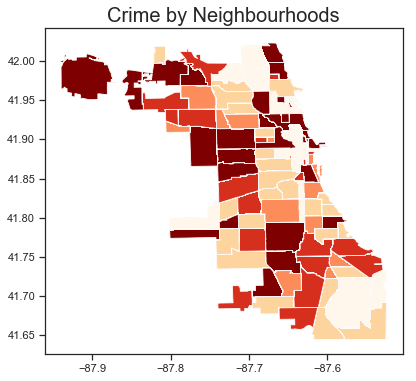

In [9]:
# Aggregate Crime by Year Month
crm_nbh = crime.groupby(['PRI_NEIGH','Mnth_yr','primary_type'])['case_number'].agg('count').reset_index()
crm_nbh.head()

# join the geodataframe with the cleaned up csv dataframe
merged = nbh.set_index('PRI_NEIGH').join(crm_nbh.set_index('PRI_NEIGH'))
variable = 'case_number'
vmin, vmax = 200, 420 # set the range for the choropleth

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
# create map
merged.plot(variable, cmap='OrRd', scheme='quantiles',linewidth=0.8, ax=ax)
ax.set_title('Crime by Neighbourhoods', fontdict={'fontsize': '20', 'fontweight' : '3'})

Text(0.5,0.98,'Crime Types by Neighbourhoods')

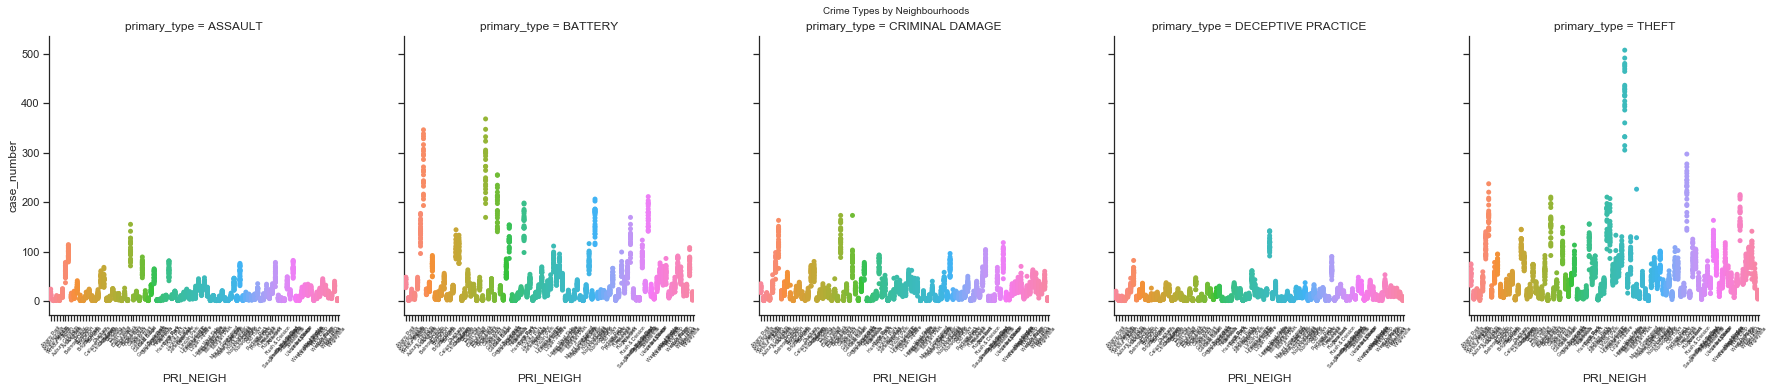

In [10]:
# Subset top categories
top_cat = ['THEFT','BATTERY','CRIMINAL DAMAGE','ASSAULT','DECEPTIVE PRACTICE']
crime_nbh_top = crm_nbh[crm_nbh.primary_type.isin(top_cat)]

g = sns.catplot(x="PRI_NEIGH", y="case_number", col = 'primary_type', jitter = False,data=crime_nbh_top)
g.set_xticklabels(rotation=50,fontsize=5)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Crime Types by Neighbourhoods',fontsize=10)

# Question 2 

### Question 2 Data Preparation: Using Spatial Join
##### Considering tract as region of analysis

In [11]:
# Extract Social Statistics Data From American Community Survey
family_income = 'B19101_001E,'
median_income='B19013_001E,'
total_population='B01003_001E,'
white='B02001_002E,'
educational_attainment='B15003_001E,'
gini='B17022_001E,' # ratio of income to poverty
variables=median_income+family_income+total_population+white+educational_attainment+gini+'NAME'
# Request
key = '6672193bb01252a3977177729df914e5a8f7f0e5'
url_acs = 'https://api.census.gov/data/2017/acs/acs5?get='+variables+'&for=tract:*&in=state:17%40county:031&key='+key

# Customised Functions for extraction 
acs_json = get_request(url_acs)
acs_df = get_data(acs_json)
acs_df.columns = acs_df.iloc[0]
acs_df.drop(acs_df.index[:1], inplace=True)
acs_df.rename(columns={'B01003_001E': 'Tot_Pop', 'B02001_002E': 'White_Race', 'B19101_001E': 'Family_Inc',
                       'B19013_001E': 'Med_Inc', 'B15003_001E': 'Educ_Atn', 'B17022_001E': 'Gini'}, inplace=True)
# Change Datatpye to Integer
acs_df[['Tot_Pop', 'White_Race','Family_Inc','Med_Inc','Educ_Atn','Gini']] = acs_df[['Tot_Pop',\
                   'White_Race','Family_Inc','Med_Inc','Educ_Atn','Gini']].astype(int)
acs_df['Other_Race'] = acs_df['Tot_Pop'].values-acs_df['White_Race'].values

In [12]:
# Import Tract Shapefile
trk_shapefile_path = "/Users/parthkhare/Desktop/MSCAPP Quarters/Quarter 2/CS Q2/Project/Data/Chicago Admin Boundaries/Census Tracts_801/CTracts_801.shp"
trk = gpd.read_file(trk_shapefile_path)
trk = trk.to_crs({'init': 'epsg:4326'}) # Set projection
# Rename merge id name
crime = crime.rename(columns={'index_right': 'mergeid_nbh'})
# Spatial Join integrated crime (with NBH) Block Shapefile to link tracts
crime_trk = gpd.sjoin(crime, trk, how="left", op = 'intersects')

In [13]:
# Aggregate Acs by Tracts (remove duplicated by block groups)
acs_trk = acs_df.groupby(['tract'])['Tot_Pop','Family_Inc','Med_Inc','Educ_Atn','White_Race','Other_Race','Gini'].agg('sum').reset_index()
# Merge ACS and Crime
acs_crm = pd.merge(left=crime_trk, right=acs_trk, left_on='tractce10', right_on='tract', how='inner')

#### Crime Social Statistics by Tract

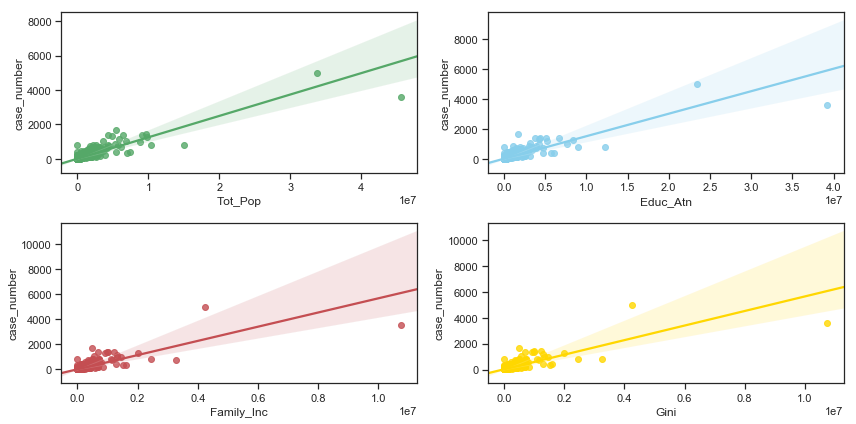

In [14]:
# Crime Trends at Tract
acr_tr = acs_crm.groupby(['tract','primary_type']).agg({'case_number':'count','Tot_Pop':'sum','Family_Inc':'sum',\
                   'Med_Inc':'sum','Educ_Atn':'sum','White_Race':'sum','Other_Race':'sum','Gini':'sum'}).reset_index()
# Plot
f, axes = plt.subplots(2, 2, figsize=(12, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
sns.regplot(y="case_number", x='Tot_Pop', color='g', data=acr_tr, ax=axes[0, 0])
sns.regplot(y="case_number", x='Educ_Atn', color='skyblue', data=acr_tr, ax=axes[0, 1])
sns.regplot(y="case_number", x ='Family_Inc', color='r', data=acr_tr, ax=axes[1, 0])
sns.regplot(y="case_number", x='Gini',color='gold', data=acr_tr, ax=axes[1, 1])
plt.tight_layout()

### Question 2.1: Battery

In [15]:
# Battery subset:
ac_bat = acs_crm[acs_crm.primary_type == 'BATTERY']
ac_bat_gp = ac_bat.groupby(['tract','primary_type']).agg({'case_number':'count','Tot_Pop':'sum','Family_Inc':'sum',\
                   'Med_Inc':'sum','Educ_Atn':'sum','White_Race':'sum','Other_Race':'sum','Gini':'sum'}).reset_index()
# Define a measure for diversity (other races proportion of population)
ac_bat_gp['diversity'] = ac_bat_gp['Other_Race']/ac_bat_gp['Tot_Pop'] 
batt=ac_bat_gp[ac_bat_gp['case_number']==ac_bat_gp['case_number'].max()]

#### In order to analyse the distibution of crime type by blocks, the following steps evaluates where do highest crime reporting blocks lie with respect to the distribution of the respective of social statistics (population, educational attainment, total family income, and diversity which is developed as proportion of other races to the total population.    

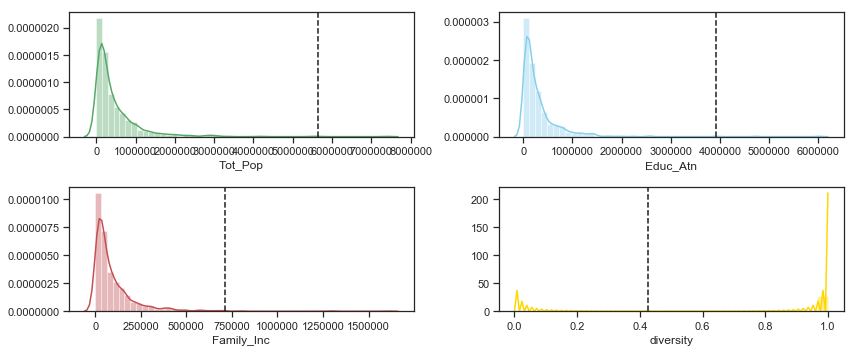

In [16]:
# Social Statistics
f, axes = plt.subplots(2, 2, figsize=(12, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
sns.distplot(ac_bat_gp['Tot_Pop'],color='g',ax=axes[0, 0]).axvline(batt['Tot_Pop'].max(), color="k", linestyle="--")
sns.distplot(ac_bat_gp['Educ_Atn'],color='skyblue',ax=axes[0, 1]).axvline(batt['Educ_Atn'].max(), color="k", linestyle="--")
sns.distplot(ac_bat_gp['Family_Inc'],color='r',ax=axes[1, 0]).axvline(batt['Family_Inc'].max(), color="k", linestyle="--")
sns.distplot(ac_bat_gp['diversity'].notnull(),color='gold',ax=axes[1, 1]).axvline(batt['diversity'].max(), color="k", linestyle="--")
plt.tight_layout()

#### Battery: The given distribution above display distribution of social indicators for the region(tract) with maximum battery offenses. As it can be seen that the type of blocks(tracts) with highest battery have very high values (in ending quartiles) for all social parameters. Possibly implying aggregation effect from higher number of population. This does not hold for diversity parameter (which is measured as a proportion of non white races to total population), which does not seems to show impact. Note: dashed line represents represents distribution of respective social statistics for the block (tract) with highest battery lies in the distribution.

### Question 2.2: Homicide

In [17]:
# Homicide subset:
ac_hom = acs_crm[acs_crm.primary_type == 'HOMICIDE']
ac_hom_gp = ac_hom.groupby(['tract','primary_type']).agg({'case_number':'count','Tot_Pop':'sum','Family_Inc':'sum',\
                   'Med_Inc':'sum','Educ_Atn':'sum','White_Race':'sum','Other_Race':'sum','Gini':'sum'}).reset_index()
# Define a measure for diversity (other races proportion of population)
ac_hom_gp['diversity'] = ac_hom_gp['Other_Race']/ac_hom_gp['Tot_Pop'] 
hom=ac_hom_gp[ac_bat_gp['case_number']==ac_hom_gp['case_number'].max()]

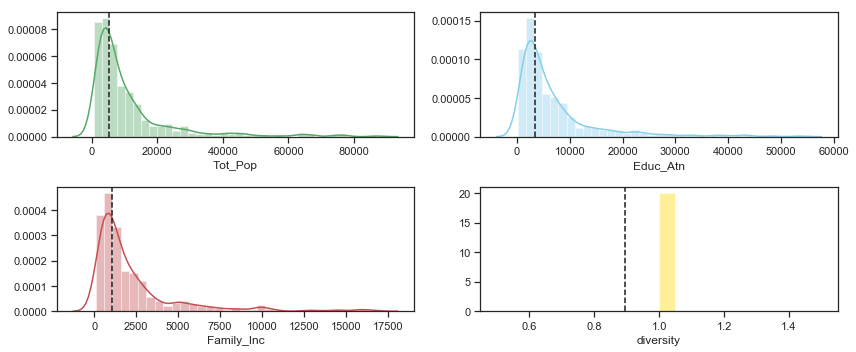

In [18]:
# Social Statistics
f, axes = plt.subplots(2, 2, figsize=(12, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
sns.distplot(ac_hom_gp['Tot_Pop'],color='g',ax=axes[0, 0]).axvline(hom['Tot_Pop'].max(), color="k", linestyle="--")
sns.distplot(ac_hom_gp['Educ_Atn'],color='skyblue',ax=axes[0, 1]).axvline(hom['Educ_Atn'].max(), color="k", linestyle="--")
sns.distplot(ac_hom_gp['Family_Inc'],color='r',ax=axes[1, 0]).axvline(hom['Family_Inc'].max(), color="k", linestyle="--")
sns.distplot(ac_hom_gp['diversity'].notnull(),color='gold',ax=axes[1, 1]).axvline(hom['diversity'].max(), color="k", linestyle="--")
plt.tight_layout()

#### Homicide: The given distribution above display distribution of social indicators for the region(tract) with maximum homicide offenses. It can be seen that, unlike battery highest homicides occue in regions where total population, educational attainment and family income are in peak(mode) of their respective distribution. Again this does not hold for diversity parameter (which is measured as a proportion of non white races to total population), which does not seems to show impact. Note: Dashed line represents distribution of respective social statistics for block (tract) with highest homicide lies in the distribution

### Question 2.3: Over time

In [19]:
# Battery subset:
ac_bat_y = ac_bat.groupby(['tract','primary_type','year']).agg({'case_number':'count','Tot_Pop':'sum','Family_Inc':'sum',\
                   'Med_Inc':'sum','Educ_Atn':'sum','White_Race':'sum','Other_Race':'sum','Gini':'sum'}).reset_index()
# Define a measure for diversity (other races proportion of population)
ac_bat_y['diversity'] = ac_bat_y['Other_Race']/ac_bat_y['Tot_Pop'] 
batt=ac_bat_gp[ac_bat_gp['case_number']==ac_bat_gp['case_number'].max()]
# Homicide subset:
ac_hom_y = ac_hom.groupby(['tract','primary_type','year']).agg({'case_number':'count','Tot_Pop':'sum','Family_Inc':'sum',\
                   'Med_Inc':'sum','Educ_Atn':'sum','White_Race':'sum','Other_Race':'sum','Gini':'sum'}).reset_index()
# Define a measure for diversity (other races proportion of population)
ac_hom_y['diversity'] = ac_hom_y['Other_Race']/ac_hom_y['Tot_Pop'] 
hom=ac_hom_y[ac_bat_y['case_number']==ac_hom_y['case_number'].max()]

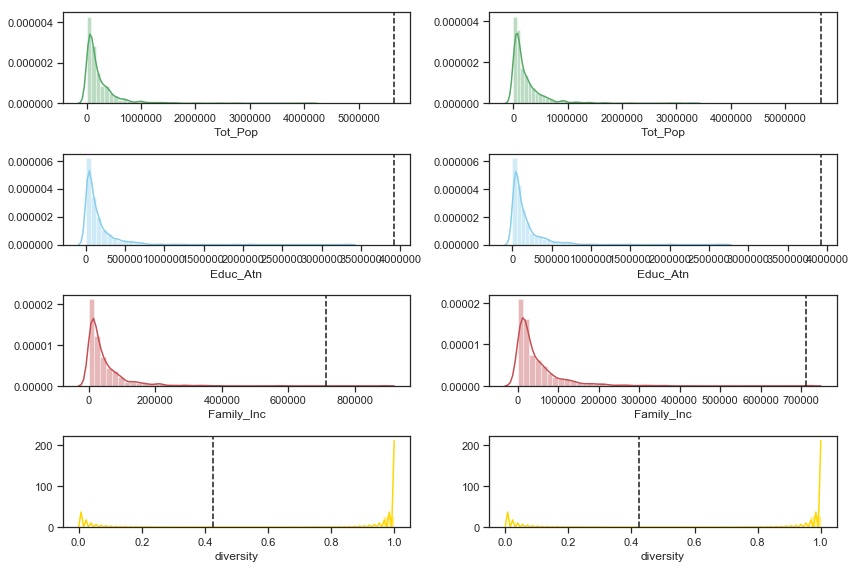

In [20]:
# Battery Changes over time
f, axes = plt.subplots(4, 2, figsize=(12, 8))
fig.subplots_adjust(hspace=5, wspace=0.8)
sns.distplot(ac_bat_y[ac_bat_y['year']=='2017']['Tot_Pop'],color='g',ax=axes[0, 0]).axvline(batt['Tot_Pop'].max(), color="k", linestyle="--")
sns.distplot(ac_bat_y[ac_bat_y['year']=='2018']['Tot_Pop'],color='g',ax=axes[0, 1]).axvline(batt['Tot_Pop'].max(), color="k", linestyle="--")
sns.distplot(ac_bat_y[ac_bat_y['year']=='2017']['Educ_Atn'],color='skyblue',ax=axes[1, 0]).axvline(batt['Educ_Atn'].max(), color="k", linestyle="--")
sns.distplot(ac_bat_y[ac_bat_y['year']=='2018']['Educ_Atn'],color='skyblue',ax=axes[1, 1]).axvline(batt['Educ_Atn'].max(), color="k", linestyle="--")
sns.distplot(ac_bat_y[ac_bat_y['year']=='2017']['Family_Inc'],color='r',ax=axes[2, 0]).axvline(batt['Family_Inc'].max(), color="k", linestyle="--")
sns.distplot(ac_bat_y[ac_bat_y['year']=='2018']['Family_Inc'],color='r',ax=axes[2, 1]).axvline(batt['Family_Inc'].max(), color="k", linestyle="--")
sns.distplot(ac_bat_y[ac_bat_y['year']=='2017']['diversity'].notnull(),color='gold',ax=axes[3, 0]).axvline(batt['diversity'].max(), color="k", linestyle="--")
sns.distplot(ac_bat_y[ac_bat_y['year']=='2018']['diversity'].notnull(),color='gold',ax=axes[3, 1]).axvline(batt['diversity'].max(), color="k", linestyle="--")
plt.tight_layout()

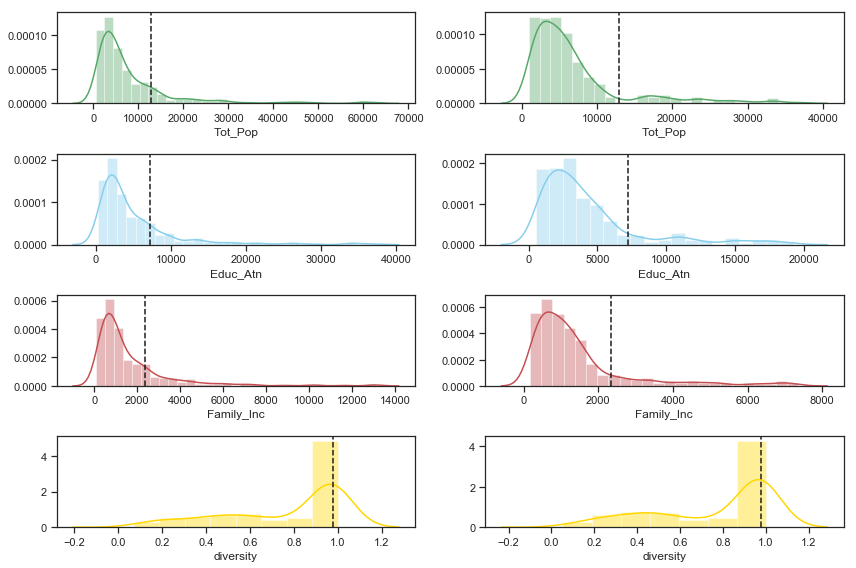

In [21]:
# Homcide Changes over time
f, axes = plt.subplots(4, 2, figsize=(12, 8))
fig.subplots_adjust(hspace=5, wspace=0.8)
sns.distplot(ac_hom_y[ac_hom_y['year']=='2017']['Tot_Pop'],color='g',ax=axes[0, 0]).axvline(hom['Tot_Pop'].max(), color="k", linestyle="--")
sns.distplot(ac_hom_y[ac_hom_y['year']=='2018']['Tot_Pop'],color='g',ax=axes[0, 1]).axvline(hom['Tot_Pop'].max(), color="k", linestyle="--")
sns.distplot(ac_hom_y[ac_hom_y['year']=='2017']['Educ_Atn'],color='skyblue',ax=axes[1, 0]).axvline(hom['Educ_Atn'].max(), color="k", linestyle="--")
sns.distplot(ac_hom_y[ac_hom_y['year']=='2018']['Educ_Atn'],color='skyblue',ax=axes[1, 1]).axvline(hom['Educ_Atn'].max(), color="k", linestyle="--")
sns.distplot(ac_hom_y[ac_hom_y['year']=='2017']['Family_Inc'],color='r',ax=axes[2, 0]).axvline(hom['Family_Inc'].max(), color="k", linestyle="--")
sns.distplot(ac_hom_y[ac_hom_y['year']=='2018']['Family_Inc'],color='r',ax=axes[2, 1]).axvline(hom['Family_Inc'].max(), color="k", linestyle="--")
sns.distplot(ac_hom_y[ac_hom_y['year']=='2017']['diversity'],color='gold',ax=axes[3, 0]).axvline(hom['diversity'].max(), color="k", linestyle="--")
sns.distplot(ac_hom_y[ac_hom_y['year']=='2018']['diversity'],color='gold',ax=axes[3, 1]).axvline(hom['diversity'].max(), color="k", linestyle="--")
plt.tight_layout()

#### Plots above show the difference in distribution of social statistics over time, dasher line representing block (tract) with highest Battery and Homicide rate respectively. Figures in left are from 2017 and on the right are from 2018. On comparing it can be seen, distribution across years not changing much, there has been relatively more change highest Homicide block(tract) as compared to Battery.

In [22]:
# Deceptive Practice:
ac_dcp = acs_crm[acs_crm.primary_type == 'DECEPTIVE PRACTICE']
ac_dcp_gp = ac_dcp.groupby(['tract','primary_type']).agg({'case_number':'count','Tot_Pop':'sum','Family_Inc':'sum',\
  'Med_Inc':'sum','Educ_Atn':'sum','White_Race':'sum','Other_Race':'sum','Gini':'sum'}).reset_index()
# Define a measure for diversity (other races proportion of population)
ac_dcp_gp['diversity'] = ac_dcp_gp['Other_Race']/ac_dcp_gp['Tot_Pop'] 
dcp=ac_dcp_gp[ac_dcp_gp['case_number']==ac_dcp_gp['case_number'].max()]
# Sex Offense:
ac_sof = acs_crm[acs_crm.primary_type == 'SEX OFFENSE']
ac_sof_gp = ac_sof.groupby(['tract','primary_type']).agg({'case_number':'count','Tot_Pop':'sum','Family_Inc':'sum',\
  'Med_Inc':'sum','Educ_Atn':'sum','White_Race':'sum','Other_Race':'sum','Gini':'sum'}).reset_index()
# Define a measure for diversity (other races proportion of population)
ac_sof_gp['diversity'] = ac_sof_gp['Other_Race']/ac_sof_gp['Tot_Pop'] 
sof=ac_sof_gp[ac_bat_gp['case_number']==ac_sof_gp['case_number'].max()]

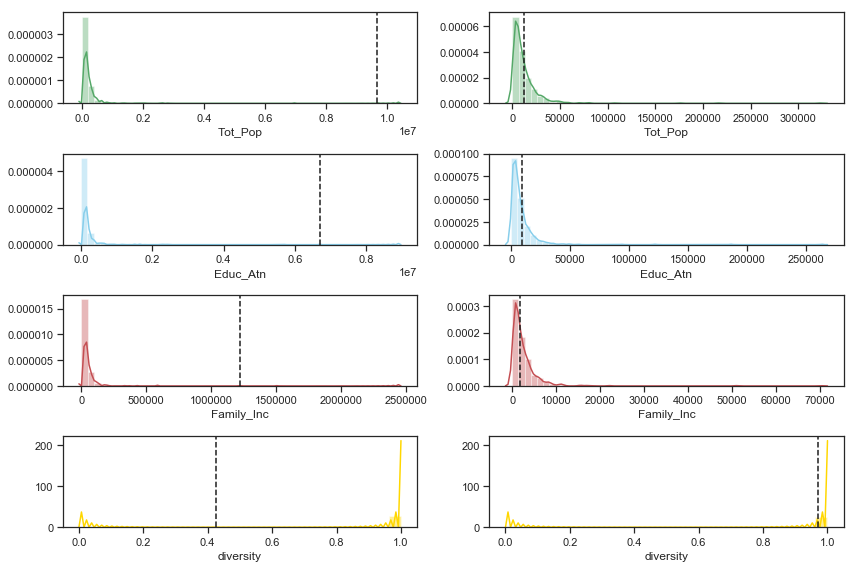

In [23]:
# dcpcide Changes over time
f, axes = plt.subplots(4, 2, figsize=(12, 8))
fig.subplots_adjust(hspace=5, wspace=0.8)
sns.distplot(ac_dcp_gp['Tot_Pop'],color='g',ax=axes[0, 0]).axvline(dcp['Tot_Pop'].max(), color="k", linestyle="--")
sns.distplot(ac_sof_gp['Tot_Pop'],color='g',ax=axes[0, 1]).axvline(sof['Tot_Pop'].max(), color="k", linestyle="--")
sns.distplot(ac_dcp_gp['Educ_Atn'],color='skyblue',ax=axes[1, 0]).axvline(dcp['Educ_Atn'].max(), color="k", linestyle="--")
sns.distplot(ac_sof_gp['Educ_Atn'],color='skyblue',ax=axes[1, 1]).axvline(sof['Educ_Atn'].max(), color="k", linestyle="--")
sns.distplot(ac_dcp_gp['Family_Inc'],color='r',ax=axes[2, 0]).axvline(dcp['Family_Inc'].max(), color="k", linestyle="--")
sns.distplot(ac_sof_gp['Family_Inc'],color='r',ax=axes[2, 1]).axvline(sof['Family_Inc'].max(), color="k", linestyle="--")
sns.distplot(ac_dcp_gp['diversity'].notnull(),color='gold',ax=axes[3, 0]).axvline(dcp['diversity'].max(), color="k", linestyle="--")
sns.distplot(ac_sof_gp['diversity'].notnull(),color='gold',ax=axes[3, 1]).axvline(sof['diversity'].max(), color="k", linestyle="--")
plt.tight_layout()

#### Left Panel: Deceptive Practice, Right Panel: Sex Offense. Block (tracts) with Deceptive Practice offense are relatively densely populated with higher incomes, implying an aggregation effect.

# Question 3

### Question 3.1

In [24]:
# Aggregating Data by Year
cy=crime.groupby(['year']).agg({'case_number':'count'}).reset_index()
cyt=crime.groupby(['year','primary_type']).agg({'case_number':'count'}).reset_index() # crime type
cyw=crime.groupby(['year','ward']).agg({'case_number':'count'}).reset_index() # wards

#### There has been 0.71% reduction in total number of reported cases from 2017 to 2018 [2017:264178, 2018:262291]

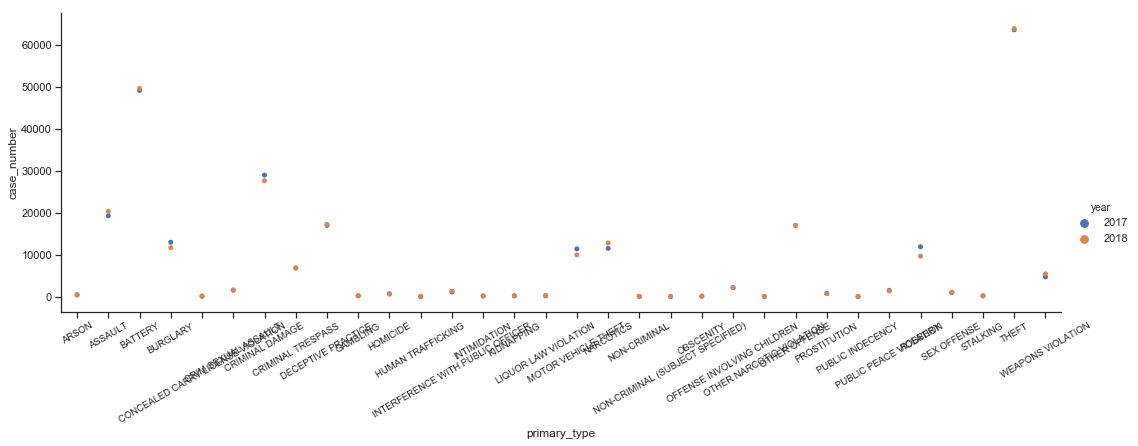

In [25]:
# Aggregating Data by Year
g = sns.catplot(x="primary_type", y="case_number", hue="year",jitter=False, data=cyt,height=5, aspect=3, ci=195)
g.set_xticklabels(rotation=30,fontsize=9.5)
g.set_titles("Change by Type")

#### Change over year across primary types: perceptable changes across liquor law violation, crime sexual assault, public peace violence, assualt

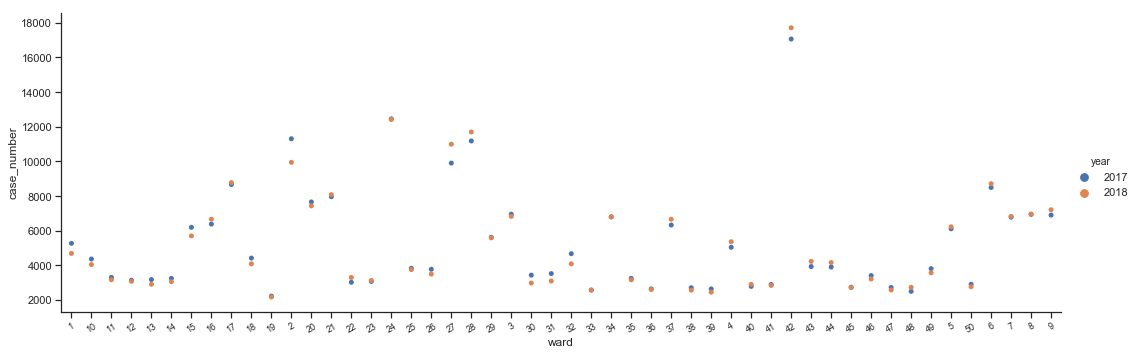

In [26]:
g = sns.catplot(x="ward", y="case_number", hue="year", jitter=False, data=cyw,height=5, aspect=3)
g.set_xticklabels(rotation=30,fontsize=9)

#### Change over year across wards: perceptable changes across wards 2,27,42,31,32

### Question 3.2

In [27]:
# Prepare data for month leading to 26th July 2017
start_date17 = '2017-07-01'
end_date17 = '2017-07-26'
mask17 = (crime['date'] > start_date17) & (crime['date'] <= end_date17)
cr_17=crime.loc[mask17]
# Prepare data for month leading to 26th July 2017
start_date18 = '2018-07-01'
end_date18 = '2018-07-26'
mask18 = (crime['date'] > start_date18) & (crime['date'] <= end_date18)
cr_18=crime.loc[mask18]

In [28]:
# Robbery
print('Robbery%:',((cr_18['primary_type'].value_counts()['ROBBERY']-cr_17['primary_type'].value_counts()['ROBBERY'])/cr_17\
['primary_type'].value_counts()['ROBBERY'])*100)
# Burglaries
print('Burglaries%:',((cr_18['primary_type'].value_counts()['BURGLARY']-cr_17['primary_type'].value_counts()['BURGLARY'])/cr_17\
['primary_type'].value_counts()['BURGLARY'])*100)
# Batteries
print('Batteries%:',((cr_18['primary_type'].value_counts()['BATTERY']-cr_17['primary_type'].value_counts()['BATTERY'])/cr_17\
['primary_type'].value_counts()['BATTERY'])*100)
# Motor Vehicle Theft
print('Motor Vehicle Theft%:',((cr_18['primary_type'].value_counts()['MOTOR VEHICLE THEFT']-cr_17['primary_type'].value_counts()['MOTOR VEHICLE THEFT'])/cr_17\
['primary_type'].value_counts()['MOTOR VEHICLE THEFT'])*100)
# Total
print('Total Crime%:',((cr_18['primary_type'].value_counts().sum()-cr_17['primary_type'].value_counts().sum())/cr_17\
 ['primary_type'].value_counts().sum())*100)

Robbery%: -13.144963144963146
Burglaries%: -6.24360286591607
Batteries%: 6.503849216883461
Motor Vehicle Theft%: -13.527180783817952
Total Crime%: 1.2943674790170896


#### The statistics do not match with the reports for period from 1st July to 26th July period in 2017 and 2018. Total crime as well as by the categories does not match even in terms of direction let alone the magnitude and seems misleading overall. The increase in total crime for the reference period is much lower than the stated % in the report as well. Yet another constestable fact is choice of the month to showcase these statistics. Seasonallly crime in Chicago is highest during summer particularly around June and July. Notwithstanding the seriousness of issue, one should bear caution in not only showing period with highest crime to rouse but also compare any other time period if not average.  

### Question 3.3

#### * Crime (across major categories) is highest during summer months and therefore deployment should address this. * Theft remains to be major crime type across neighbourhoods for both years. *  There is 20% arrest rate overall which can improved. * Furthermore, arrest rate is quite low for high intensity crimes like Theft, Battery and Criminal Damages. * Crime is relatively high for regions with higher population and total income so higher deployment can help in those regions . * Crime is higher in more racially diverse/segregated regions as well which can addressed by sentised deployment policeforce. Also no clear spatial pattern of crime density can be directly inferred we can see similar region reporting high crime across 2017 and 2018.

### Question 3.4

#### The current analysis time frame is limited in terms of time period. Two years of data maybe limiting in terms of understanding behavioural, demographic, geographical features affecting crime. In other words the social or other conditions that lead to crime, or increase/decrease in criminal activity might be difficult to track within the given time frame, as financial, demographic (including  education, race), behavioural etc features take time to change. Hence one main limitation is to be able to identify causal reason for crime. 

In [31]:
crime.primary_type.value_counts()

THEFT                                127455
BATTERY                               98750
CRIMINAL DAMAGE                       56562
ASSAULT                               39551
DECEPTIVE PRACTICE                    34166
OTHER OFFENSE                         33908
BURGLARY                              24603
NARCOTICS                             24251
ROBBERY                               21509
MOTOR VEHICLE THEFT                   21306
CRIMINAL TRESPASS                     13667
WEAPONS VIOLATION                     10105
OFFENSE INVOLVING CHILDREN             4313
CRIM SEXUAL ASSAULT                    3127
PUBLIC PEACE VIOLATION                 2855
INTERFERENCE WITH PUBLIC OFFICER       2388
SEX OFFENSE                            2000
PROSTITUTION                           1451
HOMICIDE                               1260
ARSON                                   815
LIQUOR LAW VIOLATION                    454
GAMBLING                                392
STALKING                        

# Question 4

### Question 4.1

          PRI_NEIGH        SEC_NEIGH    SHAPE_AREA     SHAPE_LEN  \
63  Near South Side  NEAR SOUTH SIDE  3.425258e+07  26884.589204   

                                             geometry  
63  POLYGON ((-87.61665903158642 41.85779360897209...  


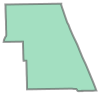

In [32]:
# Geocode the Address
add = cg.onelineaddress('2111 S Michigan Ave, Chicago, US')
# Extract Lat Long from the query 
incident = Point(add[0].get('coordinates').get('x'), add[0].get('coordinates').get('y'))
qry = nbh.contains(incident)
# Identify Neighborhood Polygon containing the geocded address 
geo = [i for i, x in enumerate(qry) if x]
print(nbh.iloc[geo]) # Near South Side
nbh.geometry[63] 

In [33]:
cns = crime[crime['PRI_NEIGH'] == 'Near South Side']
cns['primary_type'].value_counts(normalize=True)

THEFT                                0.308723
BATTERY                              0.156214
DECEPTIVE PRACTICE                   0.133694
CRIMINAL DAMAGE                      0.091505
ASSAULT                              0.061574
OTHER OFFENSE                        0.061288
MOTOR VEHICLE THEFT                  0.044755
ROBBERY                              0.040194
CRIMINAL TRESPASS                    0.034208
BURGLARY                             0.025086
NARCOTICS                            0.009407
SEX OFFENSE                          0.005986
CRIM SEXUAL ASSAULT                  0.005701
OFFENSE INVOLVING CHILDREN           0.004846
WEAPONS VIOLATION                    0.004846
PUBLIC PEACE VIOLATION               0.003136
PROSTITUTION                         0.001710
LIQUOR LAW VIOLATION                 0.001425
ARSON                                0.000855
HOMICIDE                             0.000855
STALKING                             0.000855
OBSCENITY                         

#### Theft is highest; probabilities (relative frequencies) shown above

### Question 4.2

In [34]:
crime_thft = crime[crime.primary_type == 'THEFT']
crime_thft_gp = crime_thft.groupby(['PRI_NEIGH','primary_type'])['case_number'].agg('count').reset_index()
loc = ['Garfield Park', 'Uptown']
crime_thft_lc = crime_thft_gp[crime_thft_gp.PRI_NEIGH.isin(loc)]
crime_thft_lc['PercentTheft'] = (crime_thft_lc['case_number']*100)/crime_thft_gp.case_number.sum()
crime_thft_lc

,PRI_NEIGH,primary_type,case_number,PercentTheft
31,Garfield Park,THEFT,2489,1.960923
86,Uptown,THEFT,1956,1.541007


In [35]:
crime_batt = crime[crime.primary_type == 'BATTERY']
crime_batt_gp = crime_batt.groupby(['PRI_NEIGH','primary_type'])['case_number'].agg('count').reset_index()
loc = ['Garfield Park', 'Uptown']
crime_batt_lc = crime_batt_gp[crime_batt_gp.PRI_NEIGH.isin(loc)]
crime_batt_lc['PercentBatt'] = (crime_batt_lc['case_number']*100)/crime_batt_gp.case_number.sum()
crime_batt_lc

,PRI_NEIGH,primary_type,case_number,PercentBatt
31,Garfield Park,BATTERY,4569,4.635473
86,Uptown,BATTERY,1370,1.389932


#### From amongst all crimes Garfield Park Neighbourhood is 3.25% more likely to report Battery

### Question 4.3

#### Based on the data probabilities of the total 260 Battery calls 160 call are from Uptown and 100 from Garfield Park. Therefore 62% calls from Uptown and 38% Garfield Park. So Uptown is 24% more likely to report Battery

In [ ]:
### FIN